# Week 10 Problem Set


In [50]:
# %load_ext nb_mypy
# %nb_mypy On

In [51]:
from typing import TypeAlias
from typing import Optional, Any    

Number: TypeAlias = int | float

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import seaborn as sns
from IPython.display import display

## Cohort Session

**CS0.** *Plot:* Read data for Boston Housing Prices and write a function `get_features_targets()` to get the columns for the features and the targets from the input argument data frame. The function should take in Pandas' dataframe and two lists. The first list is for the feature names and the other list is for the target names. 

We will use the following columns for our test cases:
- x data: RM column - use z normalization (standardization)
- y data: MEDV column

**Make sure you return a new data frame for both the features and the targets.**

We will normalize the feature using z normalization. Plot the data using scatter plot. 



In [53]:
def normalize_z(array: np.ndarray, 
                columns_means: Optional[np.ndarray]=None, 
                columns_stds: Optional[np.ndarray]=None) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    if (columns_means is None):
        columns_means = array.mean(axis=0)
    if (columns_stds is None):
        columns_stds = array.std(axis=0)
    
    out = (array - columns_means) / columns_stds    
    
    return out, columns_means, columns_stds


In [54]:
def get_features_targets(df: pd.DataFrame, 
                         feature_names: list[str], 
                         target_names: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    
    df_feature = df[feature_names]
    df_target = df[target_names]
    
    return df_feature, df_target

In [55]:
df: pd.DataFrame = pd.read_csv("housing_processed.csv")
df_feature, df_target = get_features_targets(df,["RM"],["MEDV"])
array_feature,_,_ = normalize_z(df_feature.to_numpy())

assert isinstance(array_feature, np.ndarray)
assert isinstance(df_target, pd.DataFrame)
assert np.isclose(array_feature.mean(), 0.0)
assert np.isclose(array_feature.std(), 1.0)
assert np.isclose(df_target.mean(), 22.532806)
assert np.isclose(df_target.std(), 9.1971)


In [56]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


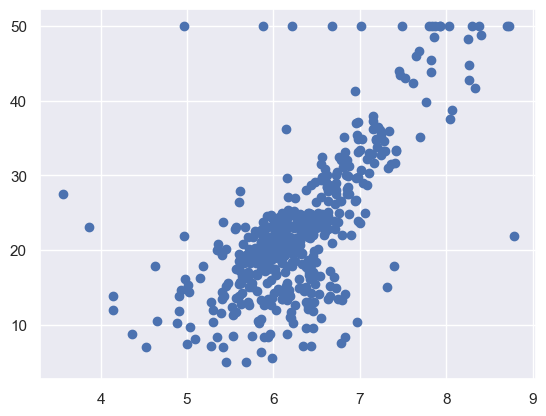

In [57]:
sns.set()
plt.scatter(df_feature, df_target)

**CS1.** *Cost Function:* Write a function `compute_cost_linreg()` to compute the cost function of a linear regression model. The function should take in two 2-D numpy arrays. The first one is the matrix of the linear equation and the second one is the actual target value.

Recall that:

$$J(\hat{\beta}_0, \hat{\beta}_1) = \frac{1}{2m}\Sigma^m_{i=1}\left(\hat{y}(x^i)-y^i\right)^2$$

where

$$\hat{y}(x^i) = \hat{\beta}_0 + \hat{\beta}_1 x^i$$

The function should receive a numpy array, so we will need to convert to numpy array and change the shape. To do this, we will create three other functions:
- `calc_linreg(X, b)`: which is used to calculate the $\hat{y} = Xb$ vector.
- `prepare_feature(df)`: which takes in a two-dimensional numpy array for the feature. The function should also add a column of constant 1s in the first column.

You can use the following methods in your code:
- `df.to_numpy()`: which is to convert a Pandas data frame to Numpy array.
- `np.reshape(row, col)`: which is to reshape the numpy array to a particular shape.
- `np.concatenate((array1, array2), axis)`: which is to join a sequence of arrays along an existing axis.
- `np.matmul(array1, array2)`: which is to do matrix multiplication on two Numpy arrays.
- `np.squeeze()`: to reduce the numpy array to a single number.


In [58]:
def calc_linreg(X: np.ndarray, beta: np.ndarray) -> np.ndarray:
    return np.matmul(X, beta)

In [59]:
def compute_cost_linreg(X: np.ndarray, y: np.ndarray, beta: np.ndarray) -> np.ndarray:
    y_hat = calc_linreg(X, beta)
    m = X.shape[0]
    
    J = (1/(2*m)) * np.matmul((y_hat-y).T, y_hat-y)
    return np.squeeze(J)


In [60]:
def prepare_feature(np_feature: np.ndarray) -> np.ndarray:
    ones = np.ones(shape = (np_feature.shape[0], 1))
    
    return np.concatenate((ones, np_feature), axis = 1)

In [61]:
X: np.ndarray = prepare_feature(df_feature.to_numpy())
target: np.ndarray = df_target.to_numpy()

assert isinstance(X, np.ndarray)
assert isinstance(target, np.ndarray)
assert X.shape == (506, 2)
assert target.shape == (506, 1)

In [62]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [63]:
# print(X)
beta: np.ndarray = np.zeros((2,1))
J: np.ndarray = compute_cost_linreg(X, target, beta)
print(J)
assert np.isclose(J, 296.0735)

beta: np.ndarray = np.ones((2,1))
J: np.ndarray = compute_cost_linreg(X, target, beta)
print(J)
assert np.isclose(J, 154.2249)

beta: np.ndarray = np.array([-1, 2]).reshape((2,1))
J: np.ndarray = compute_cost_linreg(X, target, beta)
print(J)
assert np.isclose(J, 94.3256)


296.0734584980238
154.22493384090902
94.3256152055336


In [64]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


**CS2.** *Gradient Descent:* Write a function called `gradient_descent_linreg()` that takes in these parameters:
- `X`: is a 2-D numpy array for the features
- `y`: is a vector array for the target
- `beta`: is a column vector for the initial guess of the parameters
- `alpha`: is the learning rate
- `num_iters`: is the number of iteration to perform

The function should return two numpy arrays:
- `beta`: is coefficient at the end of the iteration
- `J_storage`: is the array that stores the cost value at each iteration

You can use some of the following functions:
- `calc_linreg(X, b)`: which is used to calculate $y = Xb$ vector.
- `np.matmul(array1, array2)`: which is to do matrix multiplication on two Numpy arrays.
- `compute_cost_linreg()`: which the function you created in the previous problem set to compute the cost.

In [65]:
def gradient_descent_linreg(X: np.ndarray, y: np.ndarray, beta: np.ndarray, 
                            alpha: float, num_iters: int) -> tuple[np.ndarray, np.ndarray]:
    m = X.shape[0]
    J_storage = np.zeros(shape = (num_iters))
    
    for item in range(num_iters):
        print(X.shape, beta.shape)
        beta = beta - (alpha/m) * np.matmul(X.T, calc_linreg(X, beta)- y)
        J_storage[item] = compute_cost_linreg(X, y, beta)
        
    return beta, J_storage

In [66]:
iterations: int = 1500
alpha: float = 0.001
beta: np.ndarray = np.zeros((2,1))

beta, J_storage = gradient_descent_linreg(X, target, beta, alpha, iterations)
print(beta)
assert np.isclose(beta[0], -0.069488, rtol=1e-3)
assert np.isclose(beta[1], 3.6626356, rtol=1e-3)

(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2) (2, 1)
(506, 2)

In [67]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [68]:
J_storage

array([274.66968131, 254.98408748, 236.87874906, ...,  29.17607254,
        29.17589517,  29.17571781])

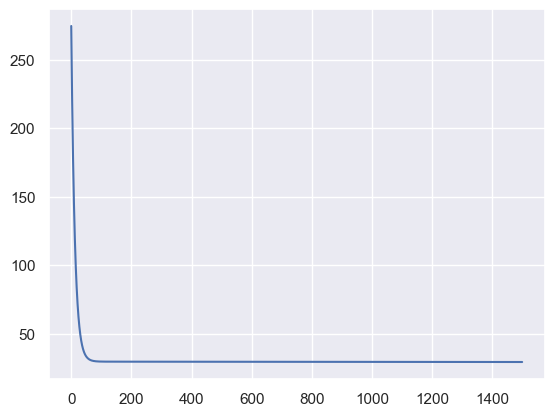

In [69]:
plt.plot(J_storage)

**CS3.** *Predict:* Write the function `predict_linreg()` that calculates the straight line equation given the features and its coefficient.
- `predict_linreg()`: this function should standardize the feature using z normalization, change it to a Numpy array, and add a column of constant 1s. You should use `prepare_feature()` for this purpose. Lastly, this function should also call `calc_linreg()` to get the predicted y values.

You can use some of the following functions:
- `calc_linreg(X, beta)`: which is used to calculate the predicted y after X has been normalized and added by a constant.
- `np.matmul(array1, array2)`: which is to do matrix multiplication on two Numpy arrays.
- `normalize_z(df)`: which is to do z normalization on the data frame.

In [70]:
def predict_linreg(array_feature: np.ndarray, beta: np.ndarray, 
                   means: Optional[np.ndarray]=None, 
                   stds: Optional[np.ndarray]=None) -> np.ndarray:
    
    X, means, stds = normalize_z(array_feature, means, stds)
    X = prepare_feature(X)
    
    return calc_linreg(X, beta)

In [71]:
df_feature, buf = get_features_targets(df, ["RM"], [])
beta: np.ndarray = np.array([[22.53279993],[ 6.39529594]]) # from previous result
pred: np.ndarray = predict_linreg(df_feature.to_numpy(), beta)

assert isinstance(pred, np.ndarray)
assert pred.shape == (506, 1)
assert np.isclose(pred.mean(), 22.5328, rtol=1e-3)
print(pred.std())
assert np.isclose(pred.std(), 6.3953, rtol=1e-3)

6.39529594


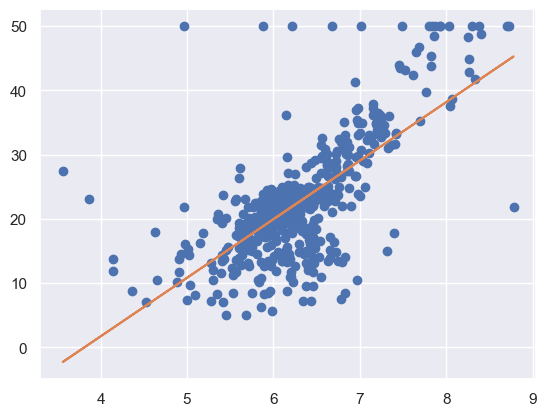

In [72]:
plt.plot(df_feature["RM"],target,'o')
plt.plot(df_feature["RM"],pred,'-')

In [73]:
means: np.ndarray = np.array([6.284634])
stds: np.ndarray = np.array([0.702617])
beta: np.ndarray = np.array([[22.53279993],[ 6.39529594]]) # from previous result
input_1row: np.ndarray = np.array([[6.593]])
pred_1row: np.ndarray = predict_linreg(input_1row, beta, means, stds)
assert np.isclose(pred_1row[0][0], 25.33958)

In [74]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


**CS4.** *Splitting data:* Do the following tasks:
- Read RM as the feature and MEDV as the target from the data frame.
- Use Week 9's function `split_data()` to split the data into train and test using `random_state=100` and `test_size=0.3`. 
- Normalize and prepare the features and the target.
- Use the training data set and call `gradient_descent_linreg()` to obtain the `theta`.
- Use the test data set to get the predicted values.

You need to replace the `None` in the code below with other a function call or any other Python expressions. 

In [75]:
def split_data(df_feature: pd.DataFrame, df_target: pd.DataFrame, 
               random_state: Optional[int]=None, 
               test_size: float=0.5) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    np.random.seed(random_state)
    index = np.random.choice(df_feature.shape[0], int(df_feature.shape[0]*test_size), replace = False)
    df_feature_train = df_feature.drop(index)
    df_feature_test = df_feature.loc[index]
    df_target_train = df_target.drop(index)
    df_target_test = df_target.loc[index]
    return df_feature_train, df_feature_test, df_target_train, df_target_test
    


In [76]:
# get features and targets from data frame
df_feature, df_target = get_features_targets(df, ["RM"], ["MEDV"])

# split the data into training and test data sets
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
array_feature_train_z, means, stds = normalize_z(df_feature_train.to_numpy())
print(array_feature_train_z.shape)

X: np.ndarray = prepare_feature(array_feature_train_z)
target: np.ndarray = df_target_train.to_numpy()

iterations: int = 1500
alpha: float = 0.01
beta: np.ndarray = np.zeros((2,1))

# call the gradient_descent function
beta, J_storage = gradient_descent_linreg(X, target, beta, alpha, iterations)

# call the predict method to get the predicted values
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta, means, stds)

###
### YOUR CODE HERE
###
print(beta)

(355, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)

In [77]:

assert isinstance(pred, np.ndarray)
assert pred.shape == (151, 1)
assert np.isclose(pred.mean(), 22.31259, rtol=1e-3)
assert np.isclose(pred.std(), 5.69332, rtol=1e-3)


In [78]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


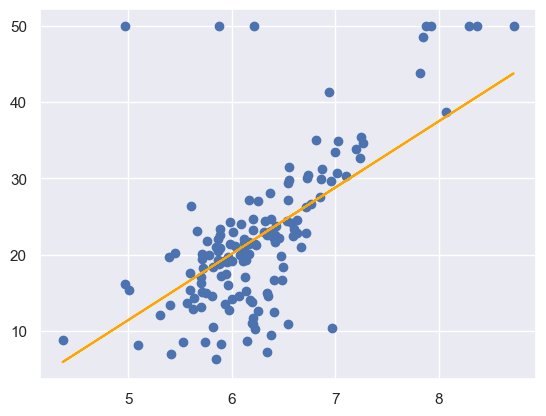

In [79]:
plt.scatter(df_feature_test, df_target_test)
plt.plot(df_feature_test, pred, color="orange")

**CS5.** Create a function `build_model_linreg()` that perform the following steps:
- change all data to numpy array.
- normalize the training feature data set using `normalize_z()` function.
- create X matrix.
- run gradient descent by calling `gradient_descent_linreg()` function.

This function should output `model` and `J_storage` where `model` is a dictionary containing `beta`, `means` and `stds`. 

In [87]:
def build_model_linreg(df_feature_train: pd.DataFrame,
                       df_target_train: pd.DataFrame,
                       beta: Optional[np.ndarray] = None,
                       alpha: float = 0.01,
                       iterations: int = 1500) -> tuple[dict[str, Any], np.ndarray]:
    if beta is None:
        beta = np.zeros((df_feature_train.shape[1] + 1, 1)) 
    assert beta.shape == (df_feature_train.shape[1] + 1, 1)
    model: dict[str, Any] = {}
    
    array_feature_train_z, means, stds = normalize_z(df_feature_train.to_numpy())

    X: np.ndarray = prepare_feature(array_feature_train_z)
    target: np.ndarray = df_target_train.to_numpy()
    
    beta, J_storage = gradient_descent_linreg(X, target, beta, alpha, iterations)
    
    model = {"beta": beta, "means": means, "stds": stds}
    J_storage = J_storage.reshape(-1, 1)
    
    return model, J_storage

In [89]:
df_feature, df_target = get_features_targets(df, ["RM"], ["MEDV"])
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model, J_storage = build_model_linreg(df_feature_train, df_target_train)
model
assert isinstance(model, dict)
assert "beta" in model
assert "means" in model
assert "stds" in model
assert model['beta'].shape == (2, 1)
assert np.isclose(model['beta'][0, 0], 22.66816258)  
assert np.isclose(model['beta'][1, 0], 6.26923893) 
assert np.isclose(model['means'], 6.2968338)
assert np.isclose(model['stds'], 0.72077827)

(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2) (2, 1)
(355, 2)

In [86]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


**CS6.** *R2 Coefficient of Determination:* Write a function to calculate the coefficient of determination as given by the following equations.

$$r^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

where

$$SS_{res} = \Sigma_{i=1}^n (y_i - \hat{y}_i)^2$$ 

where $y_i$ is the actual target value and $\hat{y}_i$ is the predicted target value.

$$SS_{tot} = \Sigma_{i=1}^n (y_i - \overline{y})^2$$

where 
$$ \overline{y} = \frac{1}{n} \Sigma_{i=1}^n y_i$$
and $n$ is the number of target values.

You can use the following functions in your code:
- `np.mean(array)`: which is to get the mean of the array. You can also call it using `array.mean()`.
- `np.sum(array)`: which is to sum the array along a default axis. You can specify which axis to perform the summation.

In [ ]:
def r2_score(y: np.ndarray, ypred: np.ndarray) -> float:
    y_mean = np.mean(y)
    
    SS_res = np.matmul((y-ypred).T, y-ypred)
    SS_tot = np.matmul((y-y_mean).T, y-y_mean)
    
    return 1 - SS_res/ SS_tot

In [ ]:
target: np.ndarray = df_target_test.to_numpy()
r2: float = r2_score(target, pred)
print(r2)
assert np.isclose(r2, 0.447557, rtol=1e-3)

In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


**CS7.** *Mean Squared Error:* Create a function to calculate the MSE as given below.

$$MSE = \frac{1}{n}\Sigma_{i=1}^n(y^i - \hat{y}^i)^2$$


In [ ]:
def mean_squared_error(target: np.ndarray, pred: np.ndarray) -> float:
    n = target.shape[0]
    return 1/n * np.matmul((target-pred).T, target-pred)

In [ ]:
mse: float = mean_squared_error(target, pred)
print(mse)
assert np.isclose(mse, 54.2684, rtol=1e-3)

In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


**CS8.** *Optional:* Redo the above tasks using Sci-kit learn libraries. You will need to use the following:
- [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
- [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)
- [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as sk_r2_score
from sklearn.metrics import mean_squared_error as sk_mse

In [ ]:
# Read the CSV and extract the features
# df: pd.DataFrame = None
df_feature, df_target = get_features_targets(df, ['RM'], ["MEDV"])
# normalize
df_feature, _, _ = normalize_z(df_feature)

###
### YOUR CODE HERE
###


In [ ]:
# Split the data into training and test data set using scikit-learn function
df_feature_train, df_feature_test, df_target_train, df_target_test = train_test_split(df_feature, df_target, random_state=100, test_size=0.3)

# Instantiate LinearRegression() object
model: LinearRegression = LinearRegression()

# Call the fit() method
model.fit(df_feature_train, df_target_train)

###
### YOUR CODE HERE
###

print(model.coef_, model.intercept_)
assert np.isclose(model.coef_,[6.05090511])
assert np.isclose(model.intercept_, 22.52999668)

In [ ]:
# Call the predict() method
pred: np.ndarray = model.predict(df_feature_test)

###
### YOUR CODE HERE
###

print(type(pred), pred.mean(), pred.std())
assert isinstance(pred, np.ndarray)
assert np.isclose(pred.mean(), 22.361699)
assert np.isclose(pred.std(), 5.7011267)

In [ ]:
plt.scatter(df_feature_test, df_target_test)
plt.plot(df_feature_test, pred, color="orange")

In [ ]:
r2: float = sk_r2_score(df_target_test, pred)
print(r2)
assert np.isclose(r2, 0.457647)

In [ ]:
mse: float = sk_mse(df_target_test, pred)
print(mse)
assert np.isclose(mse, 54.93216)